<h1 align="center">HW1 · Mel‑Spectrogram</h1>
<p align="center"><i>numpy · soundfile · matplotlib</i></p>

---


In [15]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## 1. Загрузка аудио
---

In [8]:
filename = "hello_world.wav"
y, sr = sf.read(filename)

print(y.ndim)
if y.ndim > 1:
    y = np.mean(y, axis=1)

y = y.astype(np.float32)
y = np.clip(y, -1.0, 1.0)

print(f"sr={sr}, len={len(y)}, dur={len(y)/sr:.2f}s, range=({y.min():.3f}, {y.max():.3f})")

2
sr=48000, len=191488, dur=3.99s, range=(-0.155, 0.204)


### 2. Параметры
---

In [10]:
win_length_ms = 25      
hop_length_ms = 10      
n_fft = 2048           
n_mels = 80             
fmin = 20               
fmax = sr / 2           
eps = 1e-10             

L = int(sr * win_length_ms / 1000)
H = int(sr * hop_length_ms / 1000)

print(f"L={L} samples ({win_length_ms} ms),  H={H} samples ({hop_length_ms} ms)")
print(f"n_fft={n_fft}, n_mels={n_mels}, fmin={fmin}, fmax={fmax}")


L=1200 samples (25 ms),  H=480 samples (10 ms)
n_fft=2048, n_mels=80, fmin=20, fmax=24000.0


### 3. Фрейминг и окно
---

In [11]:
w = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(L) / (L - 1))
num_frames = 1 + (len(y) - L) // H
frames = np.zeros((num_frames, L), dtype=np.float32)

for i in range(num_frames):
    start = i * H
    frames[i] = y[start:start + L] * w

print(frames.shape)


(397, 1200)


### 4. БПФ и спектр мощности
---

In [12]:

# Преобразование каждого фрейма
spec = np.fft.rfft(frames, n=n_fft, axis=1)        # комплексный спектр
power_spec = (np.abs(spec) ** 2) / n_fft           # мощность (энергия)
print(f"spec.shape = {spec.shape}")

spec.shape = (397, 1025)


### 5. Mel‑фильтробанк (HTK)
---

In [14]:
def hz_to_mel(f): 
    return 2595.0 * np.log10(1.0 + f / 700.0)

def mel_to_hz(m): 
    return 700.0 * (10.0**(m / 2595.0) - 1.0)

K = n_fft // 2 + 1
freqs = np.linspace(0.0, sr/2.0, K)

m_min = hz_to_mel(fmin)
m_max = hz_to_mel(fmax)
mel_points = np.linspace(m_min, m_max, n_mels + 2)
hz_points  = mel_to_hz(mel_points)

H = np.zeros((n_mels, K), dtype=np.float32)

for i in range(1, n_mels + 1):
    f_l, f_c, f_r = hz_points[i-1], hz_points[i], hz_points[i+1]
    left  = (freqs - f_l) / (f_c - f_l)
    right = (f_r - freqs) / (f_r - f_c)
    tri = np.maximum(0.0, np.minimum(left, right))
    H[i-1, :] = tri  # HTK-нормализация (пик = 1)

# проекция мощности в mel
S_mel = H @ power_spec.T     # shape: [n_mels, num_frames]
print(S_mel.shape)


(80, 397)


### 6. Лог‑Mel и визуализация
---

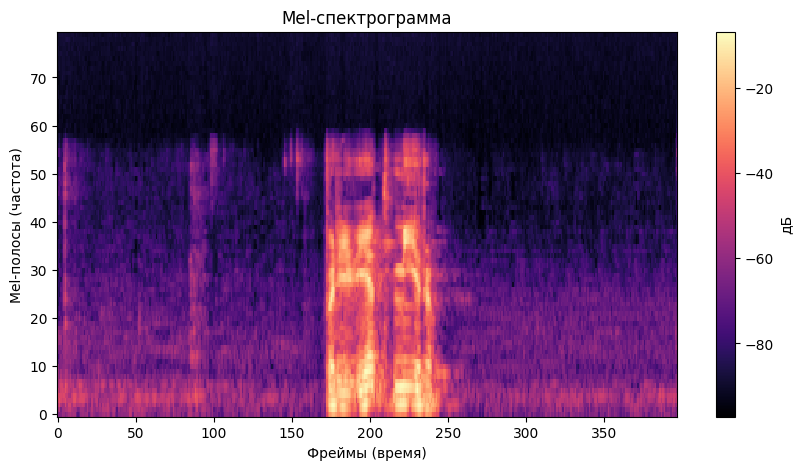

In [16]:
S_mel_db = 10 * np.log10(S_mel + 1e-10)  # в децибелах

plt.figure(figsize=(10, 5))
plt.imshow(S_mel_db, origin='lower', aspect='auto',
           cmap='magma', interpolation='nearest')
plt.title("Mel-спектрограмма")
plt.xlabel("Фреймы (время)")
plt.ylabel("Mel-полосы (частота)")
plt.colorbar(label="дБ")
plt.show()
